In [19]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from cycifsuite.get_data import read_synapse_file
from cycifsuite.combat import combat
from cycifsuite.unsupervised_analysis import *

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from functools import partial

## Read data from Synapse, which is normalized, log2 transformed, and robust scaled.
### No ComBat because everything was done in the same well.
### Note, here the pooled expr data with only mean, median, std, lawsls5/9 were used.

In [20]:
path = 'N:/HiTS Projects and Data/Personal/Jake/mcf10a'
os.chdir(path)
expr_data = pd.read_hdf('postQC_log_normed_scaled_NC_ratio.hdf')
metadata = pd.read_csv('proper_FFC_metadata.csv',index_col=0)
metadata = metadata.loc[expr_data.index]
# Select columns
valid_cols = [x for x in expr_data.columns if 'none' not in x]
dna_cols = [x for x in expr_data.columns if 'dna_4' in x]
valid_cols = [x for x in valid_cols if 'dna_' not in x]
valid_cols = valid_cols + dna_cols
expr_data = expr_data[valid_cols]

## Per well clustering
### Clustering were done in UMAP 2D space with HDBSCAN clustering.

In [44]:
metadata['pw'] = metadata.Plate.astype(str) + '_' + metadata.Well
np.random.seed(999)
output_folder = 'D:/data/MCF10A 090718 data/well_based_analysis/per_well_clustering'
clustering_func = partial(clustering_wrapper, dimention_reduction='pca+umap', 
                          use_full_dim=False, umap_min_dist=0.2, ms = 20, mcs=20)
updated_metadata = cluster_all_wells(expr_data, metadata, clustering_func, 'pw',output_dstn=output_folder, verbose=False)

508 out of 535 samples left after outlier removal
682 out of 718 samples left after outlier removal
688 out of 725 samples left after outlier removal
742 out of 781 samples left after outlier removal
676 out of 712 samples left after outlier removal
549 out of 578 samples left after outlier removal
594 out of 626 samples left after outlier removal
605 out of 637 samples left after outlier removal
708 out of 746 samples left after outlier removal
631 out of 665 samples left after outlier removal
578 out of 609 samples left after outlier removal
666 out of 701 samples left after outlier removal
571 out of 602 samples left after outlier removal
634 out of 668 samples left after outlier removal
435 out of 458 samples left after outlier removal
549 out of 578 samples left after outlier removal
328 out of 346 samples left after outlier removal
380 out of 400 samples left after outlier removal
556 out of 586 samples left after outlier removal
733 out of 772 samples left after outlier removal


## Get cluster size fractions of each well for plotting

In [45]:
# Making cluster size distribution stacked barplot
updated_metadata['s_c'] = updated_metadata.pw + '_' + updated_metadata.cluster.astype(str) 
pw_to_condition_df = updated_metadata.set_index('pw', drop=False)[['ligand','pw','time']].drop_duplicates()
crit = updated_metadata.groupby(['pw','cluster']).count()['Well']
crit = crit.groupby('pw').transform(lambda x: x/x.sum())
crit = crit.reset_index()
crit['s_c'] = crit.pw + '_' + crit.cluster.astype(str) 
bar_plot_data = crit.copy()
bar_plot_data['ligand'] = pw_to_condition_df.loc[bar_plot_data.pw,'ligand'].values
bar_plot_data['time'] = pw_to_condition_df.loc[bar_plot_data.pw,'time'].values
biggest_cluster = bar_plot_data.groupby(['pw']).max()

## Actual plotting

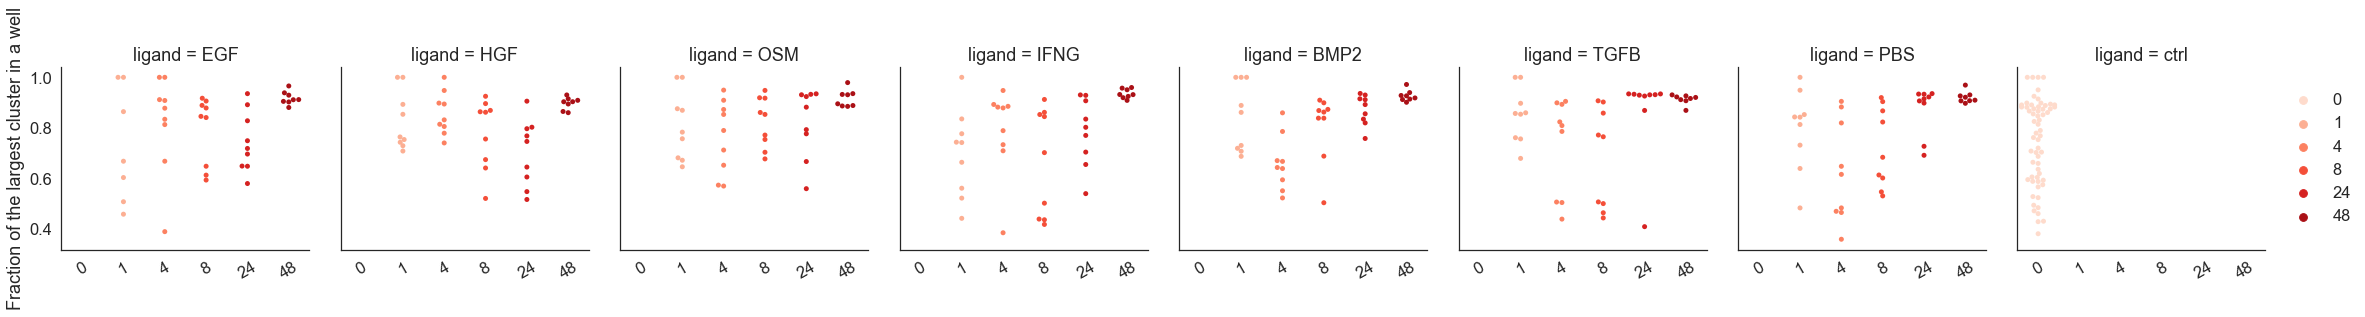

In [46]:
plot_data = biggest_cluster
sns.set(font_scale=1.5,style='white')
g = sns.catplot(x='time', y='Well', hue='time', data=plot_data, col='ligand', 
                hue_order=sorted(plot_data.time.unique()), height=4, kind='swarm', s=5,
               palette='Reds')
g.add_legend()
g.set_xticklabels(rotation=30)
g.set_ylabels('Fraction of the largest cluster in a well')
g.set_xlabels('')

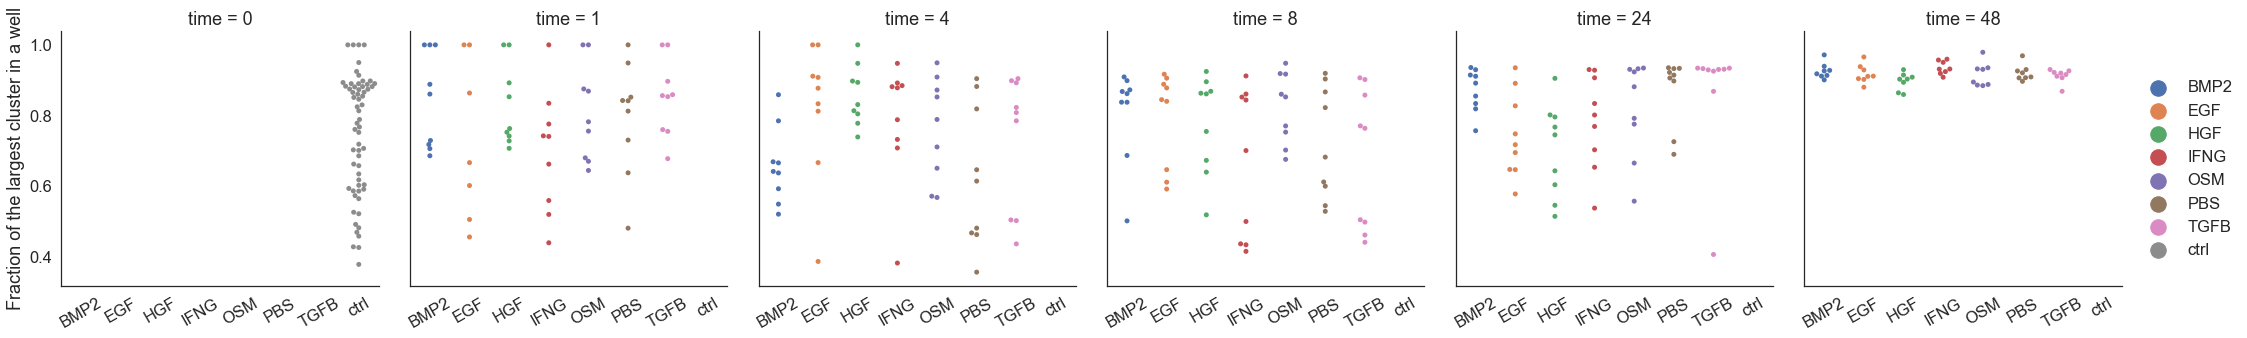

In [47]:
plot_data = biggest_cluster
sns.set(font_scale=1.5,style='white')
g = sns.catplot(x='ligand', y='Well', hue='ligand', data=plot_data, col='time', 
                hue_order=sorted(plot_data.ligand.unique()), order=sorted(plot_data.ligand.unique()),
                height=5, kind='swarm',s=5)
g.add_legend(markerscale=2)
g.set_xticklabels(rotation=30)
g.set_ylabels('Fraction of the largest cluster in a well')
g.set_xlabels('')